# Визуализация и отчётность (Jupyter)

Этот ноутбук строит графики и таблицы по витринам DBT.

Важно про **область данных**:
- Таблица `public.transactions` в этом проекте формируется из Etherscan **только по списку monitored wallets** (поле `wallet_address` = адрес, для которого делался запрос).
- Поэтому метрики `tx_count/volume/unique_wallets` в ноутбуке — это **активность выбранных кошельков**, а не «активность сети Ethereum в целом». 

Готовый текстовый анализ вынесен в Markdown (см. ниже/рядом в репозитории).


In [90]:
import os
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import sqlalchemy as sa


def env(name: str, default: str) -> str:
    return os.getenv(name, default)


POSTGRES_HOST = env("POSTGRES_HOST", "213.171.31.111")
POSTGRES_PORT = int(env("POSTGRES_PORT", "5433"))
POSTGRES_DB = env("POSTGRES_DB", "blockchain")
POSTGRES_USER = env("POSTGRES_USER", "postgres")
POSTGRES_PASSWORD = env("POSTGRES_PASSWORD", "postgres")

engine = sa.create_engine(
    f"postgresql+psycopg2://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}"
)

PREFERRED_SCHEMAS: list[str] = ["public_analytics", "analytics"]


def find_table_schema(table_name: str) -> list[str]:
    """Return schemas where table exists."""
    q = sa.text(
        """
        select table_schema
        from information_schema.tables
        where table_name = :table_name
        order by table_schema
        """
    )
    with engine.connect() as conn:
        rows = conn.execute(q, {"table_name": table_name}).fetchall()
    return [r[0] for r in rows]


def resolve_table(table_name: str, preferred_schemas: list[str] | None = None) -> str:
    schemas = find_table_schema(table_name)
    if not schemas:
        raise RuntimeError(f"Table not found: {table_name}")

    preferred_schemas = preferred_schemas or []
    for s in preferred_schemas:
        if s in schemas:
            return f"{s}.{table_name}"

    return f"{schemas[0]}.{table_name}"


def read_sql(query: str) -> pd.DataFrame:
    with engine.connect() as conn:
        return pd.read_sql(sa.text(query), conn)


DAILY_TBL = resolve_table("daily_transaction_summary", PREFERRED_SCHEMAS)
WALLET_FACT_TBL = resolve_table("fct_wallet_activity", PREFERRED_SCHEMAS)
WALLET_DIM_TBL = resolve_table("dim_wallets", PREFERRED_SCHEMAS)

DAILY_TBL, WALLET_FACT_TBL, WALLET_DIM_TBL


('public_analytics.daily_transaction_summary',
 'public_analytics.fct_wallet_activity',
 'public_analytics.dim_wallets')

In [91]:
query = """
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public'
ORDER BY table_name;
"""
public_tables = read_sql(query)
print(public_tables)

      table_name
0  overall_stats
1   transactions
2   wallet_stats
3        wallets


In [92]:
query = """
SELECT table_schema, table_name
FROM information_schema.tables
WHERE table_schema NOT IN ('pg_catalog', 'information_schema')
ORDER BY table_schema, table_name;
"""
tables = read_sql(query)
print(tables)

           table_schema                     table_name
0                public                  overall_stats
1                public                   transactions
2                public                   wallet_stats
3                public                        wallets
4      public_analytics      daily_transaction_summary
5      public_analytics                    dim_wallets
6      public_analytics            fct_wallet_activity
7            public_edr       alerts_anomaly_detection
8            public_edr              alerts_dbt_models
9            public_edr    alerts_dbt_source_freshness
10           public_edr               alerts_dbt_tests
11           public_edr          alerts_schema_changes
12           public_edr  anomaly_threshold_sensitivity
13           public_edr        data_monitoring_metrics
14           public_edr           dbt_artifacts_hashes
15           public_edr                    dbt_columns
16           public_edr                  dbt_exposures
17        

In [93]:
# Проверим структуру таблиц
transactions_info = read_sql("""
    SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_schema = 'public' AND table_name = 'transactions'
    ORDER BY ordinal_position
""")
print("Transactions columns:")
print(transactions_info)

wallets_info = read_sql("""
    SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_schema = 'public' AND table_name = 'wallets'
    ORDER BY ordinal_position
""")
print("\nWallets columns:")
print(wallets_info)

Transactions columns:
       column_name                    data_type
0               id                      integer
1             hash            character varying
2   wallet_address            character varying
3     from_address            character varying
4       to_address            character varying
5        value_eth                      numeric
6         gas_used                       bigint
7        gas_price                       bigint
8     block_number                       bigint
9         is_error                      boolean
10       timestamp  timestamp without time zone
11       loaded_at  timestamp without time zone

Wallets columns:
         column_name                    data_type
0                 id                      integer
1            address            character varying
2  transaction_count                      integer
3           added_at  timestamp without time zone
4       last_updated  timestamp without time zone
5          loaded_at  timestamp with

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Берём только последние 7 календарных дней
daily = read_sql(
    f"""
    select
        transaction_date,
        transaction_count,
        unique_wallets,
        total_volume_eth,
        failure_rate_pct,
        avg_transaction_value_eth,
        failed_transactions,
        successful_transactions
    from {DAILY_TBL}
    where transaction_date >= (CURRENT_DATE - 6)
    order by transaction_date
    """
)

daily["transaction_date"] = pd.to_datetime(daily["transaction_date"])
daily.tail(5)


,transaction_date,transaction_count,unique_wallets,total_volume_eth,failure_rate_pct,avg_transaction_value_eth,failed_transactions,successful_transactions
2,2025-12-12,27140,9,179873.316415,0.00,6.627609,0,27140
3,2025-12-13,28733,5,114093.479517,0.00,3.970817,0,28733
4,2025-12-14,29002,5,227321.437146,0.00,7.838130,0,29002
5,2025-12-15,34591,5,243081.740277,0.00,7.027312,1,34590
6,2025-12-16,17583,5,157511.095376,0.02,8.958147,4,17579


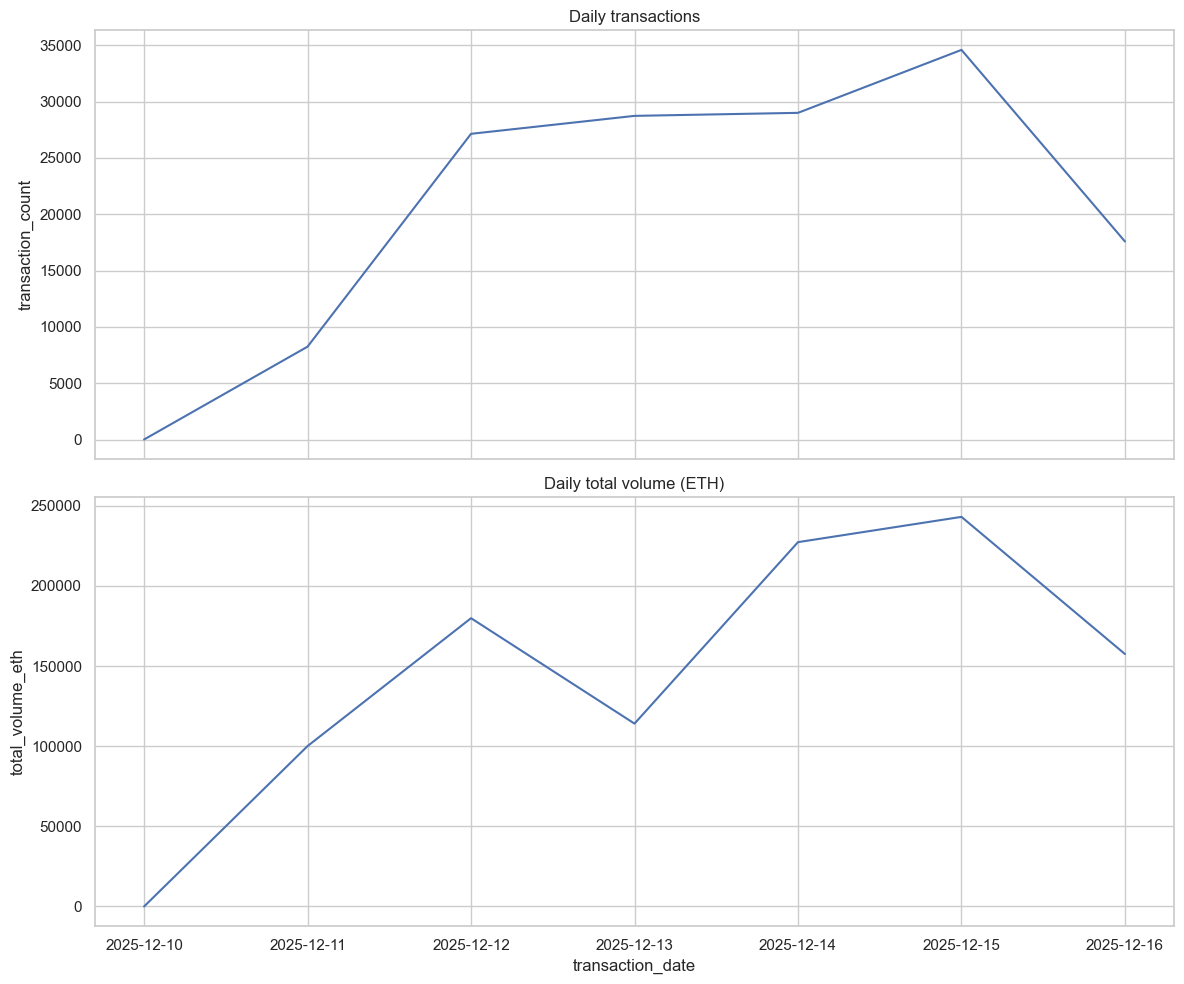

In [95]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

sns.lineplot(data=daily, x="transaction_date", y="transaction_count", ax=ax[0])
ax[0].set_title("Daily transactions")

sns.lineplot(data=daily, x="transaction_date", y="total_volume_eth", ax=ax[1])
ax[1].set_title("Daily total volume (ETH)")


plt.tight_layout()
plt.show()

# Quick numeric summary (kept as data, not as narrative text)
daily_summary_stats = None
if len(daily) > 0:
    last_7 = daily.tail(7)
    daily_summary_stats = {
        "days_covered": int((daily["transaction_date"].max() - daily["transaction_date"].min()).days) + 1,
        "last_day_tx": int(daily.iloc[-1]["transaction_count"]),
        "last_day_volume_eth": float(daily.iloc[-1]["total_volume_eth"]),
        "avg_failure_rate_last_7d_pct": float(last_7["failure_rate_pct"].mean()),
    }

daily_summary_stats


In [96]:
# Почасовая агрегация за последние 7 дней
hourly = read_sql("""
    SELECT
        DATE_TRUNC('hour', timestamp) as hour,
        COUNT(*) as tx_count,
        -- ВАЖНО: это число *мониторимых* кошельков, у которых были транзакции в этот час
        COUNT(DISTINCT wallet_address) as unique_wallets,
        COUNT(DISTINCT from_address) as unique_senders,
        COUNT(DISTINCT to_address) as unique_receivers,
        SUM(value_eth) as volume_eth,
        AVG(value_eth) as avg_value_eth,
        SUM(CASE WHEN is_error = true THEN 1 ELSE 0 END) as failed_tx,
        AVG(gas_used) as avg_gas_used,
        AVG(gas_price) as avg_gas_price
    FROM public.transactions
    WHERE timestamp >= NOW() - INTERVAL '7 days'
    GROUP BY DATE_TRUNC('hour', timestamp)
    ORDER BY hour
""")

hourly['hour'] = pd.to_datetime(hourly['hour'])
hourly['failure_rate'] = (hourly['failed_tx'] / hourly['tx_count'] * 100).fillna(0)

print(f"Hourly data: {len(hourly)} hours")
hourly.tail()

Hourly data: 118 hours


,hour,tx_count,unique_wallets,unique_senders,unique_receivers,volume_eth,avg_value_eth,failed_tx,avg_gas_used,avg_gas_price,failure_rate
113,2025-12-16 09:00:00,1493,5,314,384,8053.957531,5.394479,0,45487.687207,5.224882e+07,0.0
114,2025-12-16 10:00:00,1430,5,229,405,34462.650385,24.099756,0,46820.520280,5.643730e+07,0.0
115,2025-12-16 11:00:00,1393,5,211,347,6195.755476,4.447779,0,50223.468772,5.024134e+07,0.0
116,2025-12-16 12:00:00,1563,5,214,374,5440.797238,3.480996,0,48982.866923,4.698361e+07,0.0
117,2025-12-16 13:00:00,761,5,109,224,970.145675,1.274830,0,49052.479632,5.168785e+07,0.0


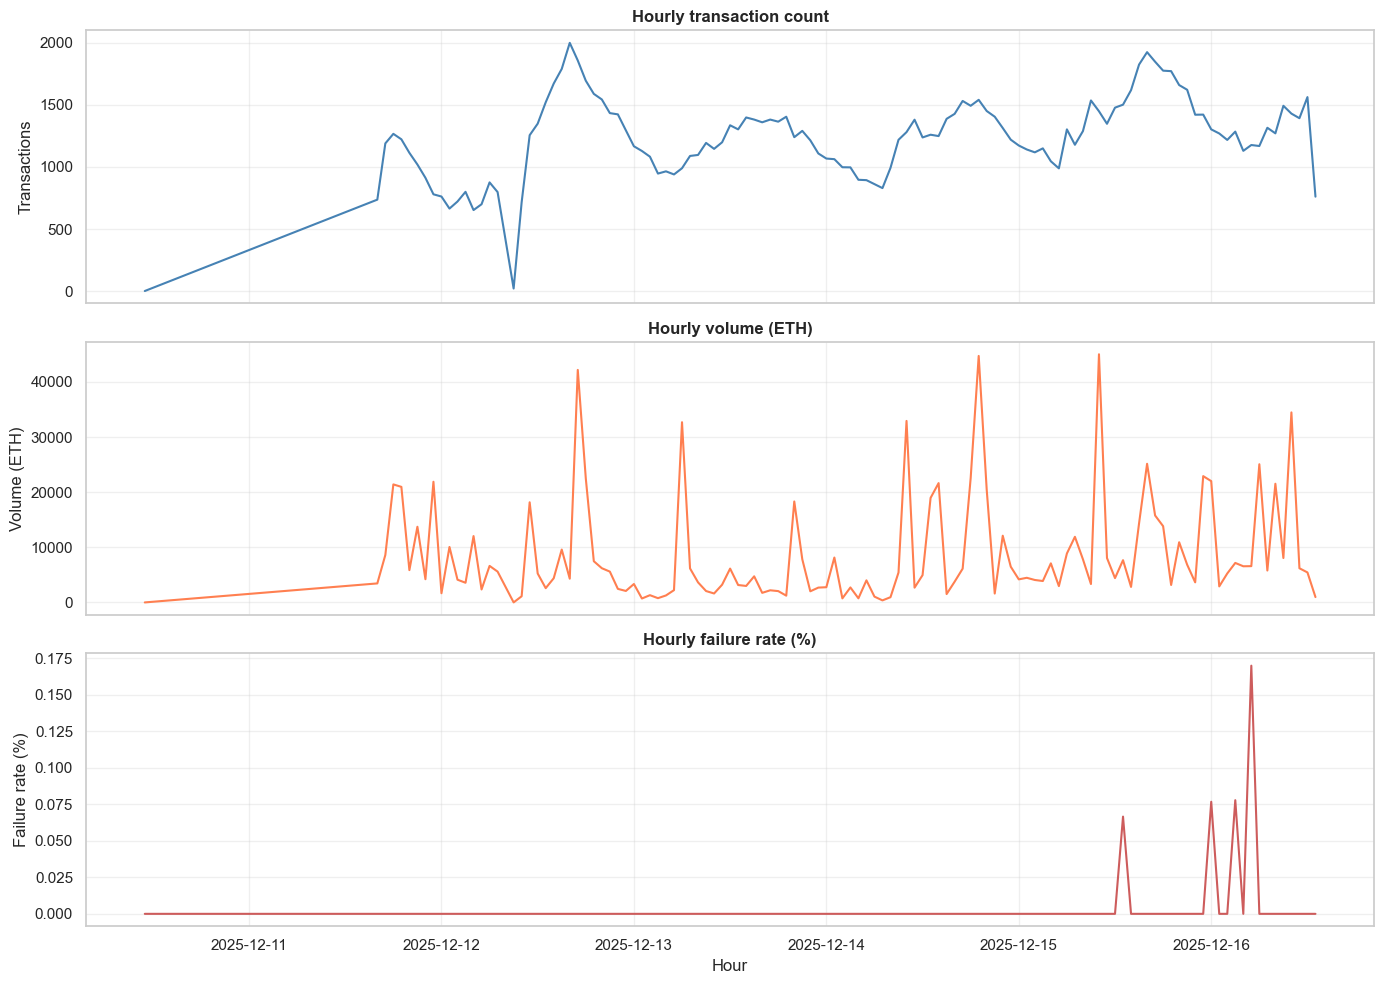

In [97]:
# Визуализация почасовых трендов
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

ax[0].plot(hourly['hour'], hourly['tx_count'], color='steelblue', linewidth=1.5)
ax[0].set_title('Hourly transaction count', fontsize=12, fontweight='bold')
ax[0].set_ylabel('Transactions')
ax[0].grid(True, alpha=0.3)

ax[1].plot(hourly['hour'], hourly['volume_eth'], color='coral', linewidth=1.5)
ax[1].set_title('Hourly volume (ETH)', fontsize=12, fontweight='bold')
ax[1].set_ylabel('Volume (ETH)')
ax[1].grid(True, alpha=0.3)

ax[2].plot(hourly['hour'], hourly['failure_rate'], color='indianred', linewidth=1.5)
ax[2].set_title('Hourly failure rate (%)', fontsize=12, fontweight='bold')
ax[2].set_ylabel('Failure rate (%)')
ax[2].set_xlabel('Hour')
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

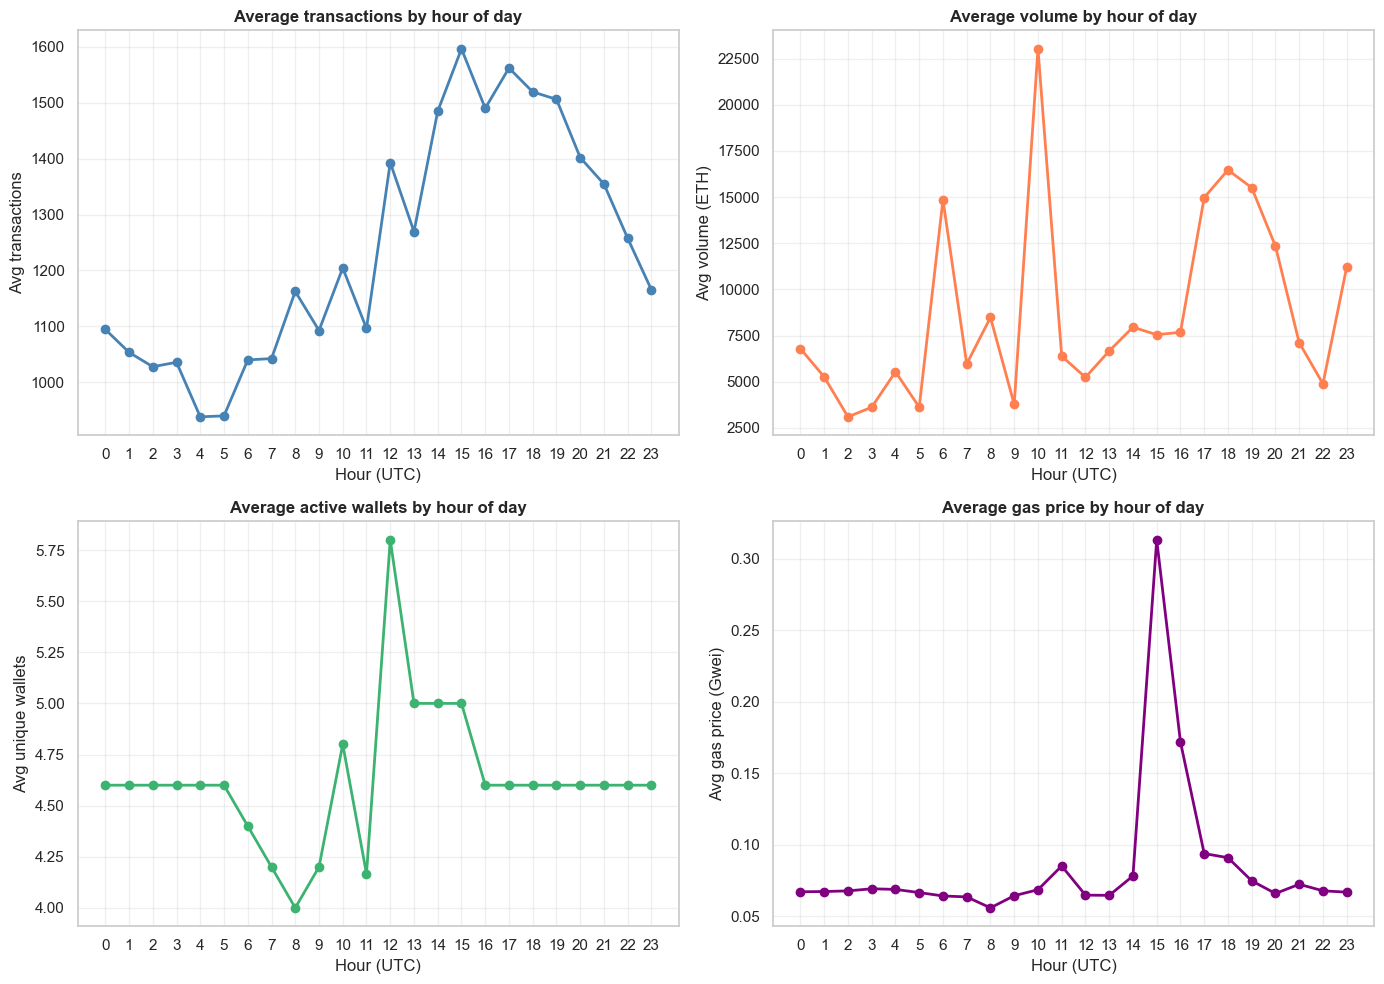


 Peak hour: 15:00 UTC
   Avg transactions: 1596
   Avg volume: 7544.57 ETH


In [98]:
# Средняя активность по часам суток (агрегация по всем дням)
hourly['hour_of_day'] = hourly['hour'].dt.hour
hourly['day_of_week'] = hourly['hour'].dt.day_name()

hourly_pattern = hourly.groupby('hour_of_day').agg({
    'tx_count': 'mean',
    'volume_eth': 'mean',
    'unique_wallets': 'mean',
    'failure_rate': 'mean',
    'avg_gas_price': 'mean'
}).reset_index()

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Transactions by hour
ax[0, 0].plot(hourly_pattern['hour_of_day'], hourly_pattern['tx_count'],
              marker='o', linewidth=2, markersize=6, color='steelblue')
ax[0, 0].set_title('Average transactions by hour of day', fontweight='bold')
ax[0, 0].set_xlabel('Hour (UTC)')
ax[0, 0].set_ylabel('Avg transactions')
ax[0, 0].set_xticks(range(0, 24))
ax[0, 0].grid(True, alpha=0.3)

# Volume by hour
ax[0, 1].plot(hourly_pattern['hour_of_day'], hourly_pattern['volume_eth'],
              marker='o', linewidth=2, markersize=6, color='coral')
ax[0, 1].set_title('Average volume by hour of day', fontweight='bold')
ax[0, 1].set_xlabel('Hour (UTC)')
ax[0, 1].set_ylabel('Avg volume (ETH)')
ax[0, 1].set_xticks(range(0, 24))
ax[0, 1].grid(True, alpha=0.3)

# Active wallets by hour
ax[1, 0].plot(hourly_pattern['hour_of_day'], hourly_pattern['unique_wallets'],
              marker='o', linewidth=2, markersize=6, color='mediumseagreen')
ax[1, 0].set_title('Average active wallets by hour of day', fontweight='bold')
ax[1, 0].set_xlabel('Hour (UTC)')
ax[1, 0].set_ylabel('Avg unique wallets')
ax[1, 0].set_xticks(range(0, 24))
ax[1, 0].grid(True, alpha=0.3)

# Gas price by hour
ax[1, 1].plot(hourly_pattern['hour_of_day'], hourly_pattern['avg_gas_price'] / 1e9,
              marker='o', linewidth=2, markersize=6, color='purple')
ax[1, 1].set_title('Average gas price by hour of day', fontweight='bold')
ax[1, 1].set_xlabel('Hour (UTC)')
ax[1, 1].set_ylabel('Avg gas price (Gwei)')
ax[1, 1].set_xticks(range(0, 24))
ax[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Найти пиковый час
peak_hour = hourly_pattern.loc[hourly_pattern['tx_count'].idxmax()]
print(f"\n Peak hour: {int(peak_hour['hour_of_day'])}:00 UTC")
print(f"   Avg transactions: {peak_hour['tx_count']:.0f}")
print(f"   Avg volume: {peak_hour['volume_eth']:.2f} ETH")

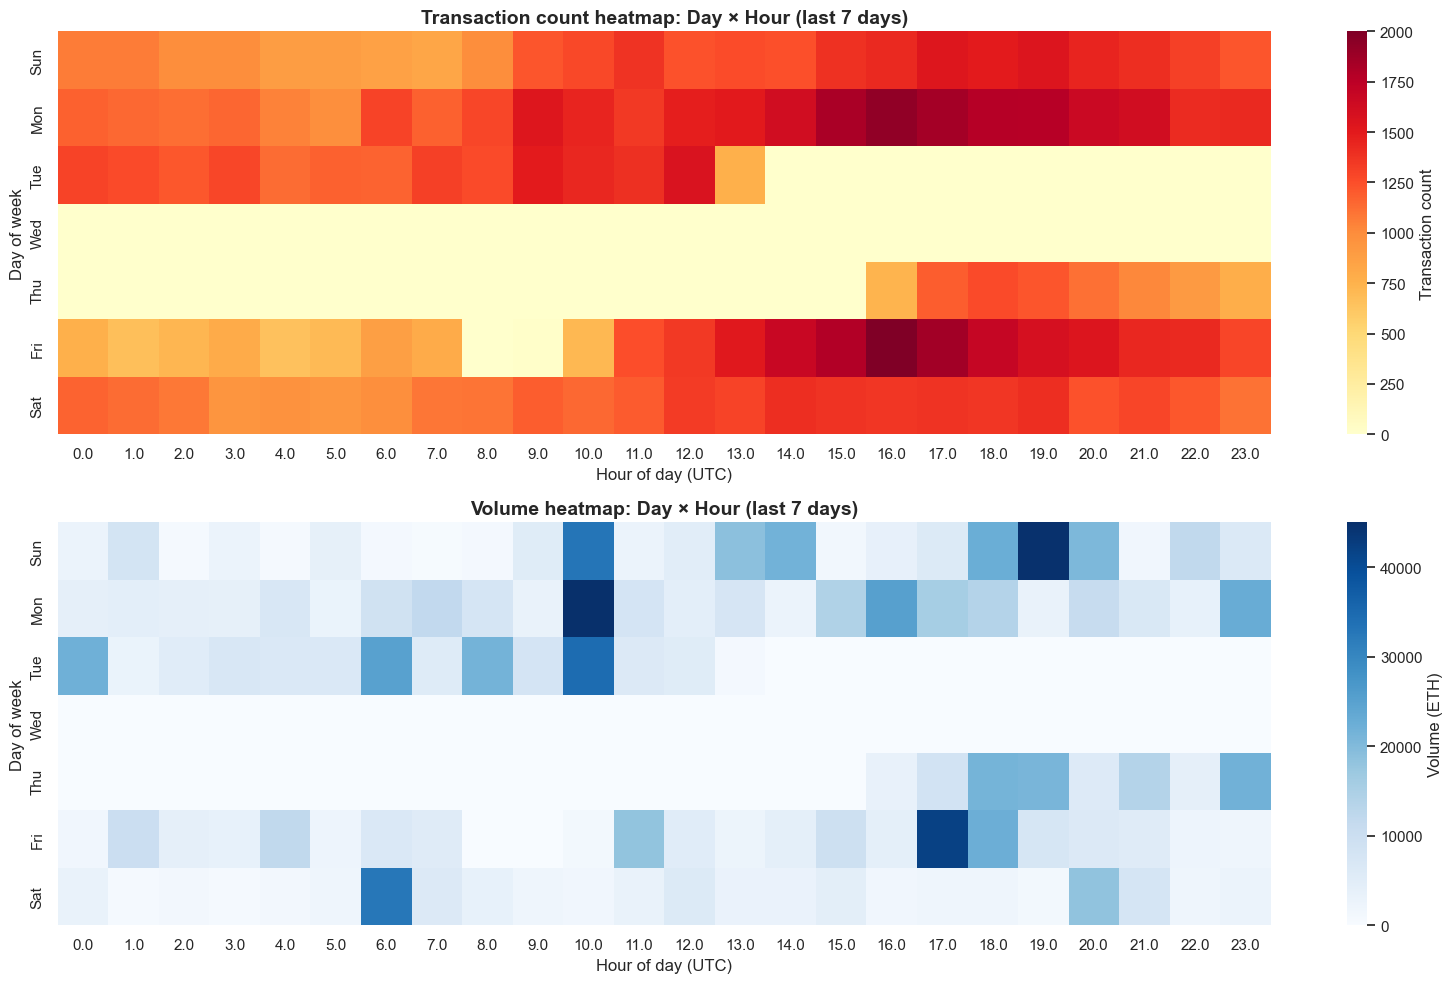


 Peak activity:
   Day: Fri
   Hour: 16:00 UTC
   Transactions: 2000


In [99]:
# Данные для тепловой карты (последние 7 дней)
heatmap_data = read_sql("""
    SELECT
        EXTRACT(DOW FROM timestamp) as day_of_week,
        EXTRACT(HOUR FROM timestamp) as hour,
        COUNT(*) as tx_count,
        SUM(value_eth) as volume_eth
    FROM public.transactions
    WHERE timestamp >= NOW() - INTERVAL '7 days'
    GROUP BY day_of_week, hour
""")

# Pivot для транзакций
heatmap_tx = heatmap_data.pivot(index='day_of_week', columns='hour', values='tx_count').fillna(0)
heatmap_vol = heatmap_data.pivot(index='day_of_week', columns='hour', values='volume_eth').fillna(0)

days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

fig, ax = plt.subplots(2, 1, figsize=(16, 10))

# Heatmap транзакций
sns.heatmap(heatmap_tx, cmap='YlOrRd', annot=False, fmt='g',
            yticklabels=days, cbar_kws={'label': 'Transaction count'}, ax=ax[0])
ax[0].set_title('Transaction count heatmap: Day × Hour (last 7 days)',
                fontsize=14, fontweight='bold')
ax[0].set_xlabel('Hour of day (UTC)')
ax[0].set_ylabel('Day of week')

# Heatmap объема
sns.heatmap(heatmap_vol, cmap='Blues', annot=False, fmt='g',
            yticklabels=days, cbar_kws={'label': 'Volume (ETH)'}, ax=ax[1])
ax[1].set_title('Volume heatmap: Day × Hour (last 7 days)',
                fontsize=14, fontweight='bold')
ax[1].set_xlabel('Hour of day (UTC)')
ax[1].set_ylabel('Day of week')

plt.tight_layout()
plt.show()

# Находим самый активный момент
max_tx_idx = heatmap_data['tx_count'].idxmax()
peak_moment = heatmap_data.loc[max_tx_idx]
print(f"\n Peak activity:")
print(f"   Day: {days[int(peak_moment['day_of_week'])]}")
print(f"   Hour: {int(peak_moment['hour'])}:00 UTC")
print(f"   Transactions: {int(peak_moment['tx_count'])}")

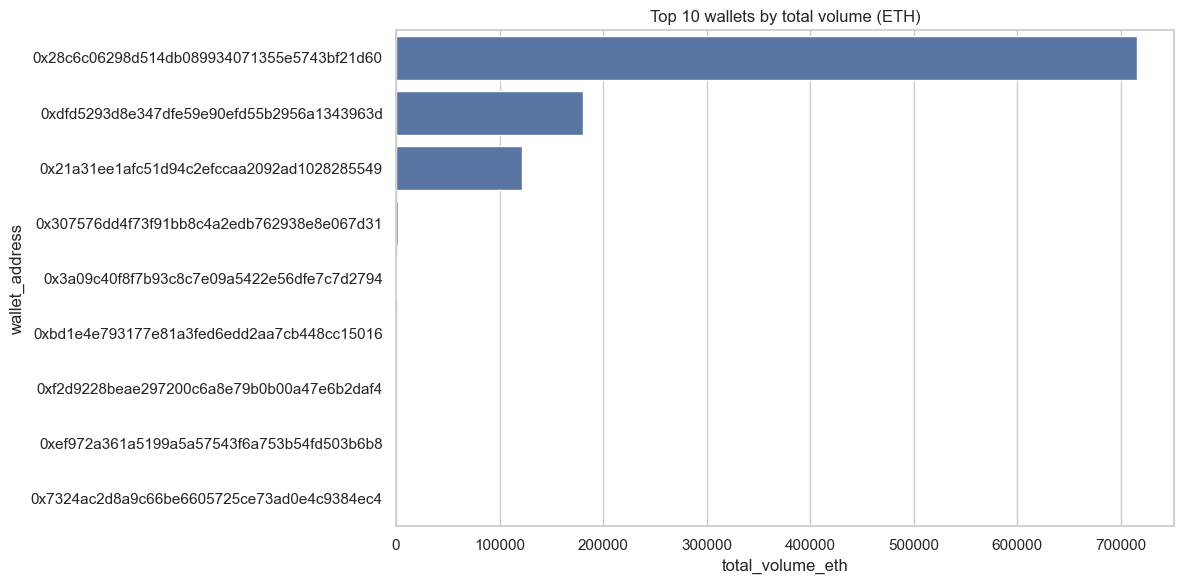

In [100]:
# --- Wallet leaderboard ---
wallets = read_sql(
    f"""
    select
        wallet_address,
        actual_tx_count,
        total_volume_eth,
        net_balance_eth,
        first_transaction_at,
        last_transaction_at,
        is_active
    from {WALLET_FACT_TBL}
    """
)

wallets["first_transaction_at"] = pd.to_datetime(wallets["first_transaction_at"], errors="coerce")
wallets["last_transaction_at"] = pd.to_datetime(wallets["last_transaction_at"], errors="coerce")

wallets = wallets.fillna({"total_volume_eth": 0, "actual_tx_count": 0, "net_balance_eth": 0})

top_n = 10
leader = wallets.sort_values("total_volume_eth", ascending=False).head(top_n)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.barplot(data=leader, x="total_volume_eth", y="wallet_address", ax=ax)
ax.set_title(f"Top {top_n} wallets by total volume (ETH)")
ax.set_xlabel("total_volume_eth")
ax.set_ylabel("wallet_address")
plt.tight_layout()
plt.show()

# concentration metric: share of volume accounted by top N
if wallets["total_volume_eth"].sum() > 0:
    share_top_n = leader["total_volume_eth"].sum() / wallets["total_volume_eth"].sum()
    {"top_n": top_n, "top_n_volume_share": float(share_top_n)}


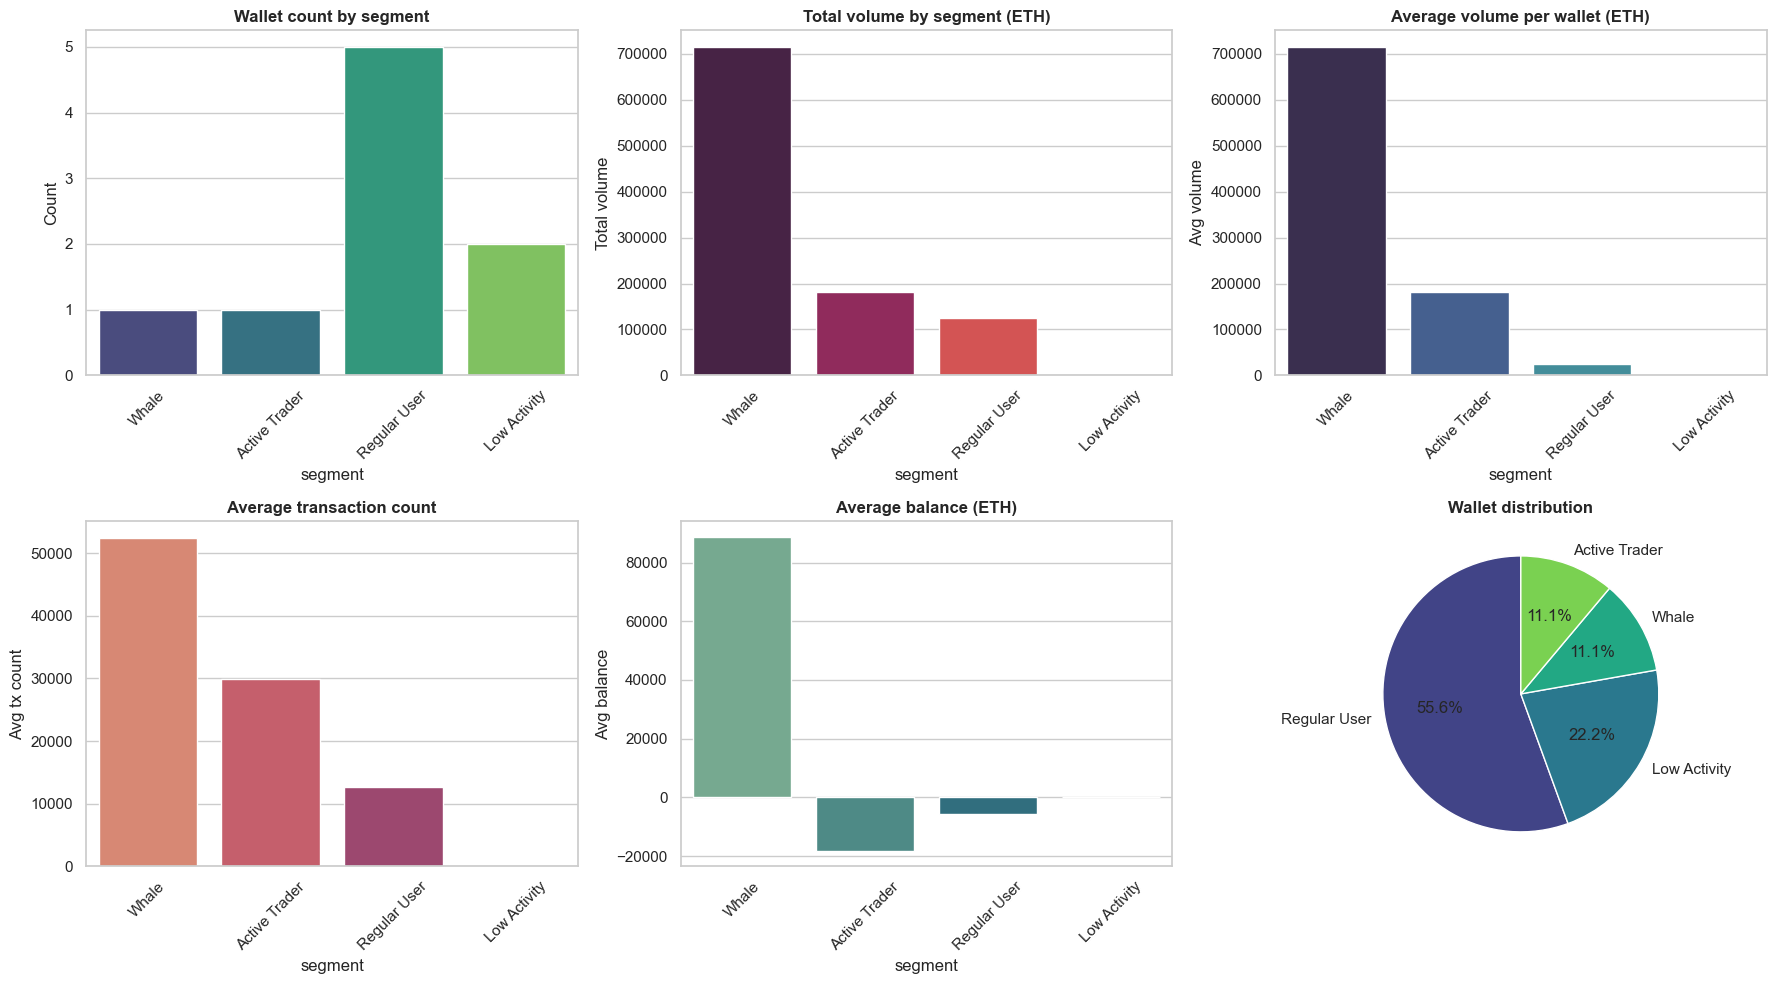

In [101]:
# Используем уже загруженные данные wallets
def segment_wallet(row):
    vol_90 = wallets['total_volume_eth'].quantile(0.9)
    vol_50 = wallets['total_volume_eth'].quantile(0.5)
    tx_75 = wallets['actual_tx_count'].quantile(0.75)
    tx_25 = wallets['actual_tx_count'].quantile(0.25)

    if row['total_volume_eth'] > vol_90:
        return 'Whale'
    elif row['total_volume_eth'] > vol_50 and row['actual_tx_count'] > tx_75:
        return 'Active Trader'
    elif row['actual_tx_count'] > tx_75:
        return 'High Frequency'
    elif row['actual_tx_count'] < tx_25 and row['total_volume_eth'] < vol_50:
        return 'Low Activity'
    elif row['actual_tx_count'] == 0:
        return 'Inactive'
    else:
        return 'Regular User'

wallets['segment'] = wallets.apply(segment_wallet, axis=1)

# Статистика по сегментам
segment_stats = wallets.groupby('segment').agg({
    'wallet_address': 'count',
    'total_volume_eth': ['sum', 'mean', 'median'],
    'actual_tx_count': ['mean', 'median'],
    'net_balance_eth': ['mean', 'median']
}).round(2)

segment_stats.columns = ['_'.join(col).strip() for col in segment_stats.columns.values]
segment_stats = segment_stats.reset_index()
segment_stats = segment_stats.sort_values('total_volume_eth_sum', ascending=False)


# Визуализация
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# 1. Количество кошельков
sns.barplot(data=segment_stats, x='segment', y='wallet_address_count',
            ax=ax[0,0], palette='viridis')
ax[0,0].set_title('Wallet count by segment', fontweight='bold')
ax[0,0].set_ylabel('Count')
ax[0,0].tick_params(axis='x', rotation=45)

# 2. Общий объем
sns.barplot(data=segment_stats, x='segment', y='total_volume_eth_sum',
            ax=ax[0,1], palette='rocket')
ax[0,1].set_title('Total volume by segment (ETH)', fontweight='bold')
ax[0,1].set_ylabel('Total volume')
ax[0,1].tick_params(axis='x', rotation=45)

# 3. Средний объем
sns.barplot(data=segment_stats, x='segment', y='total_volume_eth_mean',
            ax=ax[0,2], palette='mako')
ax[0,2].set_title('Average volume per wallet (ETH)', fontweight='bold')
ax[0,2].set_ylabel('Avg volume')
ax[0,2].tick_params(axis='x', rotation=45)

# 4. Средние транзакции
sns.barplot(data=segment_stats, x='segment', y='actual_tx_count_mean',
            ax=ax[1,0], palette='flare')
ax[1,0].set_title('Average transaction count', fontweight='bold')
ax[1,0].set_ylabel('Avg tx count')
ax[1,0].tick_params(axis='x', rotation=45)

# 5. Средний баланс
sns.barplot(data=segment_stats, x='segment', y='net_balance_eth_mean',
            ax=ax[1,1], palette='crest')
ax[1,1].set_title('Average balance (ETH)', fontweight='bold')
ax[1,1].set_ylabel('Avg balance')
ax[1,1].tick_params(axis='x', rotation=45)

# 6. Pie chart распределения
segment_counts = wallets['segment'].value_counts()
colors = sns.color_palette('viridis', len(segment_counts))
ax[1,2].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
ax[1,2].set_title('Wallet distribution', fontweight='bold')

plt.tight_layout()
plt.show()

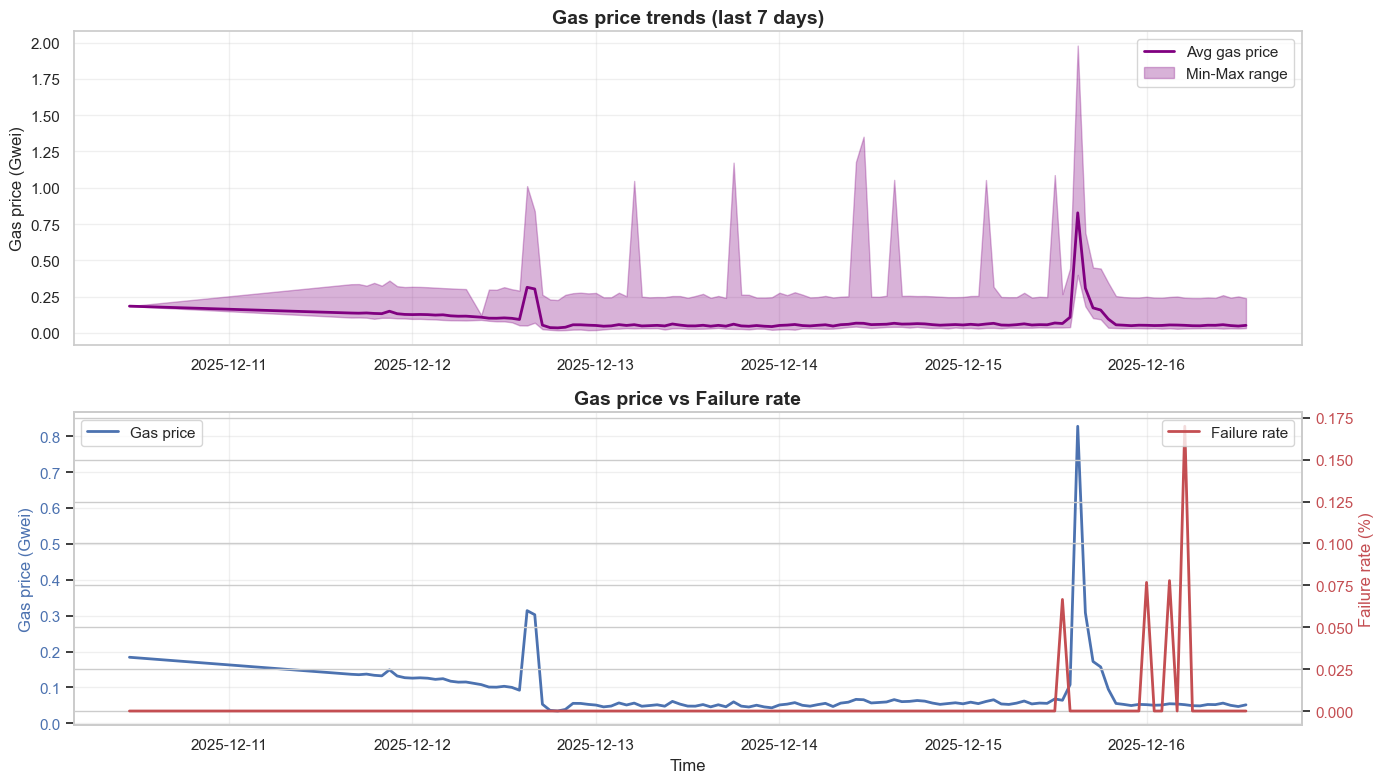

In [102]:
# Gas price тренды
gas_analysis = read_sql("""
    SELECT
        DATE_TRUNC('hour', timestamp) as hour,
        AVG(gas_price) / 1e9 as avg_gas_gwei,
        MIN(gas_price) / 1e9 as min_gas_gwei,
        MAX(gas_price) / 1e9 as max_gas_gwei,
        AVG(gas_used) as avg_gas_used,
        SUM(CASE WHEN is_error = true THEN 1 ELSE 0 END)::float / COUNT(*) * 100 as failure_rate
    FROM public.transactions
    WHERE timestamp >= NOW() - INTERVAL '7 days'
    GROUP BY DATE_TRUNC('hour', timestamp)
    ORDER BY hour
""")

gas_analysis['hour'] = pd.to_datetime(gas_analysis['hour'])

fig, ax = plt.subplots(2, 1, figsize=(14, 8))

# Gas price over time
ax[0].plot(gas_analysis['hour'], gas_analysis['avg_gas_gwei'],
           color='purple', linewidth=2, label='Avg gas price')
ax[0].fill_between(gas_analysis['hour'],
                    gas_analysis['min_gas_gwei'],
                    gas_analysis['max_gas_gwei'],
                    alpha=0.3, color='purple', label='Min-Max range')
ax[0].set_title('Gas price trends (last 7 days)', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Gas price (Gwei)', fontsize=12)
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Gas price vs failure rate
ax2 = ax[1].twinx()
ax[1].plot(gas_analysis['hour'], gas_analysis['avg_gas_gwei'],
           'b-', linewidth=2, label='Gas price')
ax2.plot(gas_analysis['hour'], gas_analysis['failure_rate'],
         'r-', linewidth=2, label='Failure rate')
ax[1].set_title('Gas price vs Failure rate', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Time', fontsize=12)
ax[1].set_ylabel('Gas price (Gwei)', color='b', fontsize=12)
ax2.set_ylabel('Failure rate (%)', color='r', fontsize=12)
ax[1].tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')
ax[1].legend(loc='upper left')
ax2.legend(loc='upper right')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

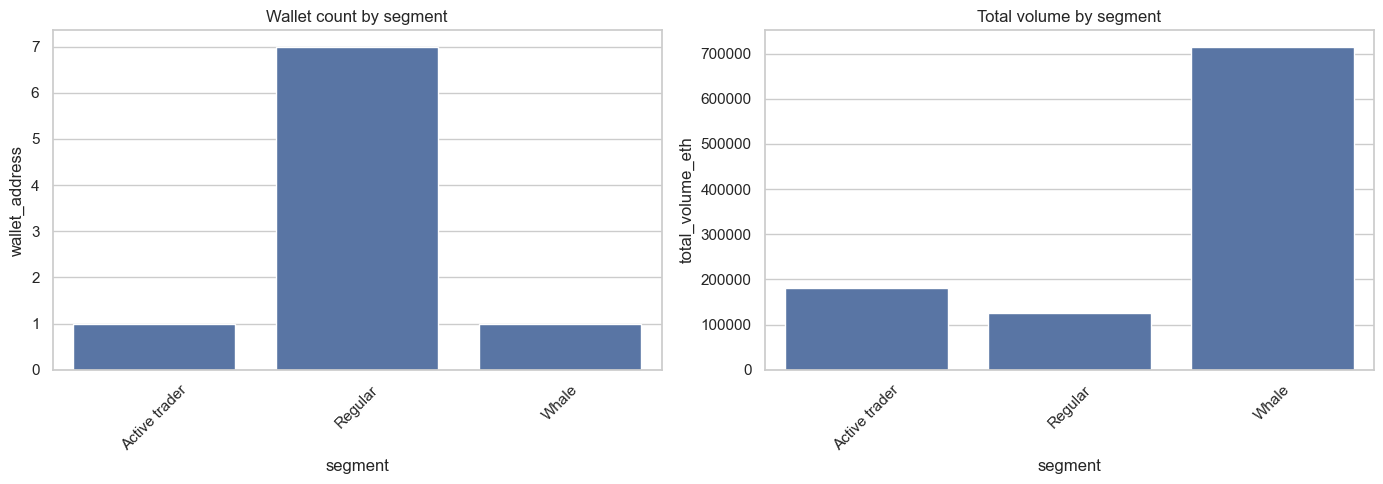

In [103]:
# Классификация по активности и объему
def segment_wallet(row):
    if row['total_volume_eth'] > wallets['total_volume_eth'].quantile(0.9):
        return 'Whale'
    elif row['actual_tx_count'] > wallets['actual_tx_count'].quantile(0.75):
        return 'Active trader'
    elif row['actual_tx_count'] == 0:
        return 'Inactive'
    else:
        return 'Regular'

wallets['segment'] = wallets.apply(segment_wallet, axis=1)

# Визуализация сегментов
segment_stats = wallets.groupby('segment').agg({
    'wallet_address': 'count',
    'total_volume_eth': 'sum',
    'net_balance_eth': 'mean'
}).reset_index()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=segment_stats, x='segment', y='wallet_address', ax=ax[0])
ax[0].set_title('Wallet count by segment')
ax[0].tick_params(axis='x', rotation=45)

sns.barplot(data=segment_stats, x='segment', y='total_volume_eth', ax=ax[1])
ax[1].set_title('Total volume by segment')
ax[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

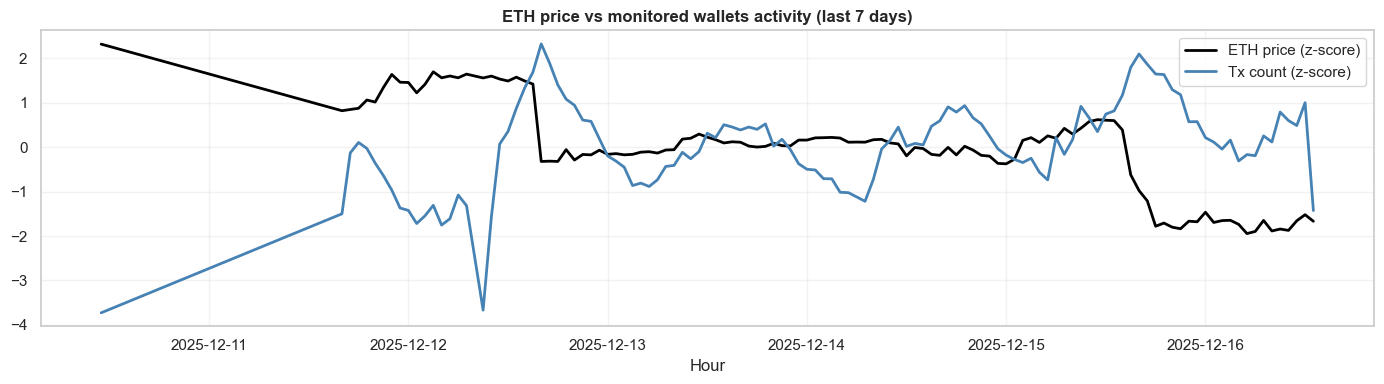

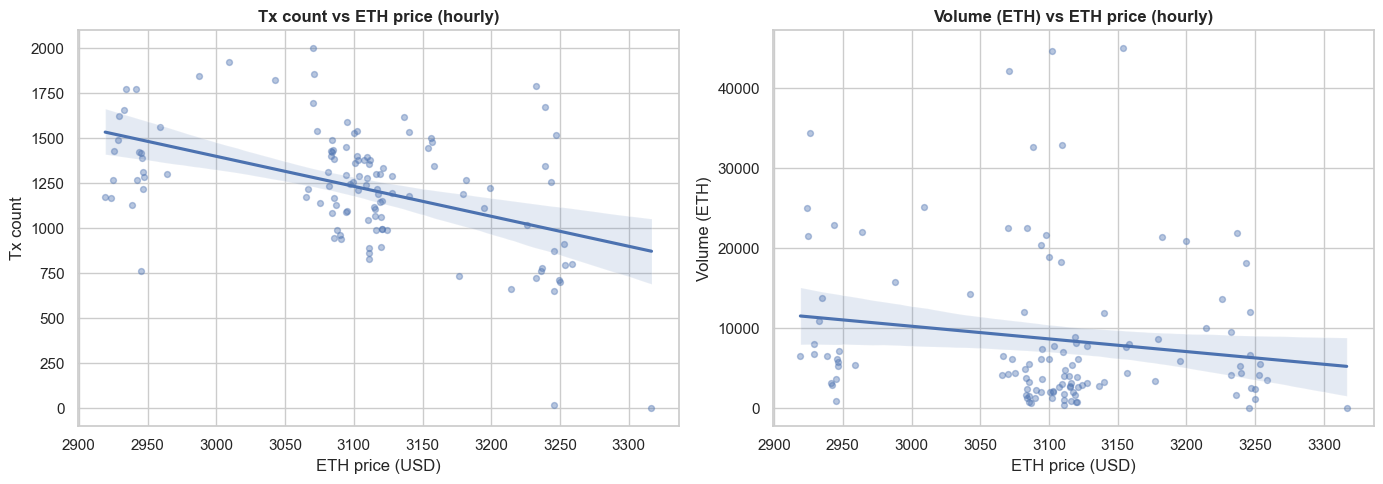


MONITORED WALLETS ACTIVITY vs ETH PRICE (last 7 days)
Level correlations:
- corr(price, tx_count): -0.470 (moderate)
- corr(price, volume_eth): -0.155 (weak)
- corr(price, unique_wallets): -0.485 (moderate)

Return correlations (hour-to-hour changes):
- corr(ret(price), ret(tx_count)): -0.483 (moderate)
- corr(ret(price), ret(volume_eth)): -0.485 (moderate)
- corr(ret(price), ret(volume_usd)): -0.485 (moderate)
- corr(ret(price), ret(unique_wallets)): -0.214 (weak)

Lag check (price move leads activity by N hours):


,lag_hours,"corr(ret(price)_t, ret(tx)_t+lag)","corr(ret(price)_t, ret(vol)_t+lag)"
0,0,-0.483331,-0.484734
1,1,-0.028970,-0.030246
2,6,0.107560,0.109945
3,12,0.135909,0.127359
4,24,0.085418,-0.218769



Largest ETH move (hourly):
- hour: 2025-12-12 16:00:00
- ETH return: -5.02% (down)
- tx_count: 2000, volume_eth: 4307.75, unique_wallets: 5

Actionable insights (interpretation is ONLY for monitored wallets sample):
- Elasticity(tx_count) via log-returns: ~-0.22 (≈ на 1% к цене → -0.22% к tx_count)
- Elasticity(volume_eth) via log-returns: ~-38.79 (≈ на 1% к цене → -38.79% к volume_eth)
- Best lag for tx_count: 0h (corr=-0.483)
- corr(ret(price), ret(tx_count)) = -0.483 (moderate)
- Daily check: corr(close_price, daily_tx) = -0.781 (strong)
- Daily check: corr(ret(price), ret(daily_tx)) = -0.282 (weak)
- Вывод: по последним 7 дням есть отрицательная связь (corr=-0.483, moderate), но это не обязательно причинность.


In [ ]:
# Сравнение метрик активности кошельков (tx_count/volume/unique_wallets) с ценой ETH.
import numpy as np
from IPython.display import display

try:
    import requests

    def fetch_eth_usd_hourly(days: int = 7) -> pd.DataFrame:
        url = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart"
        params = {"vs_currency": "usd", "days": days}
        r = requests.get(url, params=params, timeout=20)
        r.raise_for_status()
        payload = r.json()
        prices = payload.get("prices", [])
        if not prices:
            raise RuntimeError("CoinGecko returned empty prices")

        df = pd.DataFrame(prices, columns=["ts_ms", "eth_price_usd"])
        df["ts"] = pd.to_datetime(df["ts_ms"], unit="ms", utc=True)
        df = df.drop(columns=["ts_ms"]).sort_values("ts")

        df["hour"] = df["ts"].dt.floor("h")
        df = df.groupby("hour", as_index=False)["eth_price_usd"].mean()

        df["hour"] = df["hour"].dt.tz_convert(None)
        return df

    eth_price = fetch_eth_usd_hourly(days=7)

    # Join с почасовыми метриками
    if "hourly" in globals() and len(hourly) > 0:
        hourly_join = hourly.copy()
        hourly_join["hour"] = pd.to_datetime(hourly_join["hour"])

        dfh = hourly_join.merge(eth_price, on="hour", how="inner").sort_values("hour")

        # Фичи для анализа связи
        dfh["volume_usd"] = dfh["volume_eth"] * dfh["eth_price_usd"]
        dfh["eth_ret"] = dfh["eth_price_usd"].pct_change()
        dfh["tx_ret"] = dfh["tx_count"].pct_change()
        dfh["vol_ret"] = dfh["volume_eth"].pct_change().replace([np.inf, -np.inf], np.nan)
        dfh["vol_usd_ret"] = dfh["volume_usd"].pct_change().replace([np.inf, -np.inf], np.nan)
        dfh["uniq_ret"] = dfh["unique_wallets"].pct_change()

        # Базовые корреляции
        corr_level = {
            "corr(price, tx_count)": float(dfh[["eth_price_usd", "tx_count"]].corr().iloc[0, 1]),
            "corr(price, volume_eth)": float(dfh[["eth_price_usd", "volume_eth"]].corr().iloc[0, 1]),
            "corr(price, unique_wallets)": float(dfh[["eth_price_usd", "unique_wallets"]].corr().iloc[0, 1]),
        }
        corr_returns = {
            "corr(ret(price), ret(tx_count))": float(dfh[["eth_ret", "tx_ret"]].corr().iloc[0, 1]),
            "corr(ret(price), ret(volume_eth))": float(dfh[["eth_ret", "vol_ret"]].corr().iloc[0, 1]),
            "corr(ret(price), ret(volume_usd))": float(dfh[["eth_ret", "vol_usd_ret"]].corr().iloc[0, 1]),
            "corr(ret(price), ret(unique_wallets))": float(dfh[["eth_ret", "uniq_ret"]].corr().iloc[0, 1]),
        }

        # Эластичность
        dfh["dlog_price"] = np.log(dfh["eth_price_usd"]).diff()
        dfh["dlog_tx"] = np.log1p(dfh["tx_count"]).diff()
        dfh["dlog_vol_eth"] = np.log1p(dfh["volume_eth"]).diff()

        def _elasticity(x: pd.Series, y: pd.Series, min_n: int = 30) -> float:
            m = pd.concat([x, y], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
            if len(m) < min_n:
                return np.nan
            # убираем сильные выбросы (1%..99%), чтобы 1-2 часа не доминировали
            xq1, xq9 = m.iloc[:, 0].quantile([0.01, 0.99]).tolist()
            yq1, yq9 = m.iloc[:, 1].quantile([0.01, 0.99]).tolist()
            m = m[(m.iloc[:, 0].between(xq1, xq9)) & (m.iloc[:, 1].between(yq1, yq9))]
            if len(m) < min_n:
                return np.nan
            return float(np.polyfit(m.iloc[:, 0], m.iloc[:, 1], 1)[0])

        elasticity_tx = _elasticity(dfh["dlog_price"], dfh["dlog_tx"])  # tx_count vs price
        elasticity_vol = _elasticity(dfh["dlog_price"], dfh["dlog_vol_eth"])  # volume_eth vs price

        lags = [0, 1, 6, 12, 24]
        lag_rows = []
        for lag in lags:
            lag_rows.append({
                "lag_hours": lag,
                "corr(ret(price)_t, ret(tx)_t+lag)": dfh["eth_ret"].corr(dfh["tx_ret"].shift(-lag)),
                "corr(ret(price)_t, ret(vol)_t+lag)": dfh["eth_ret"].corr(dfh["vol_ret"].shift(-lag)),
            })
        lag_corr = pd.DataFrame(lag_rows)

        # Визуализации 
        import matplotlib.pyplot as plt
        import seaborn as sns

        # 1) Нормированные временные ряды
        fig, ax = plt.subplots(1, 1, figsize=(14, 4))
        z_price = (dfh["eth_price_usd"] - dfh["eth_price_usd"].mean()) / dfh["eth_price_usd"].std(ddof=0)
        z_tx = (dfh["tx_count"] - dfh["tx_count"].mean()) / dfh["tx_count"].std(ddof=0)
        ax.plot(dfh["hour"], z_price, label="ETH price (z-score)", color="black", linewidth=2)
        ax.plot(dfh["hour"], z_tx, label="Tx count (z-score)", color="steelblue", linewidth=2)
        ax.set_title("ETH price vs monitored wallets activity (last 7 days)", fontweight="bold")
        ax.set_xlabel("Hour")
        ax.legend()
        ax.grid(True, alpha=0.25)
        plt.tight_layout()
        plt.show()

        # 2) Scatter + регрессия: уровень цены vs volume
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
        sns.regplot(data=dfh, x="eth_price_usd", y="tx_count", scatter_kws={"alpha": 0.4, "s": 18}, ax=ax[0])
        ax[0].set_title("Tx count vs ETH price (hourly)", fontweight="bold")
        ax[0].set_xlabel("ETH price (USD)")
        ax[0].set_ylabel("Tx count")

        sns.regplot(data=dfh, x="eth_price_usd", y="volume_eth", scatter_kws={"alpha": 0.4, "s": 18}, ax=ax[1])
        ax[1].set_title("Volume (ETH) vs ETH price (hourly)", fontweight="bold")
        ax[1].set_xlabel("ETH price (USD)")
        ax[1].set_ylabel("Volume (ETH)")
        plt.tight_layout()
        plt.show()

        # Helpers
        def strength(x: float) -> str:
            if pd.isna(x):
                return "n/a"
            axv = abs(x)
            if axv < 0.15:
                return "very weak"
            if axv < 0.30:
                return "weak"
            if axv < 0.50:
                return "moderate"
            return "strong"

        # Самый большой рывок цены и что было с активностью
        if dfh["eth_ret"].abs().dropna().empty:
            biggest_move = None
        else:
            idx = dfh["eth_ret"].abs().idxmax()
            biggest_move = dfh.loc[idx, ["hour", "eth_ret", "eth_price_usd", "tx_count", "volume_eth", "unique_wallets"]]

        # Данные для Markdown-отчёта (без печати текстовых выводов из кода)
        price_activity_summary = {
            **corr_level,
            **corr_returns,
            "elasticity_tx": float(elasticity_tx) if not pd.isna(elasticity_tx) else np.nan,
            "elasticity_vol_eth": float(elasticity_vol) if not pd.isna(elasticity_vol) else np.nan,
        }
        price_activity_summary = pd.DataFrame([price_activity_summary])

        # Артефакты для дальнейшего использования
        price_activity_lag_corr = lag_corr.copy()
        price_activity_biggest_move = biggest_move

        display(price_activity_summary)
        display(price_activity_lag_corr)
        if price_activity_biggest_move is not None:
            display(pd.DataFrame([price_activity_biggest_move]))

        # --- Daily cross-check (на уровне дней) ---
        daily_summary = None
        if "daily" in globals() and len(daily) > 0:
            # берём "close" цену дня как последнюю цену в этот день
            eth_daily = eth_price.copy()
            eth_daily["date"] = eth_daily["hour"].dt.floor("D")
            eth_daily = eth_daily.sort_values("hour").groupby("date", as_index=False).tail(1)
            eth_daily = eth_daily[["date", "eth_price_usd"]].rename(columns={"eth_price_usd": "eth_close_usd"})

            daily_tmp = daily.copy()
            daily_tmp["date"] = pd.to_datetime(daily_tmp["transaction_date"]).dt.floor("D")
            daily_summary = daily_tmp.merge(eth_daily, on="date", how="left").sort_values("date")
            daily_summary["eth_ret_d"] = daily_summary["eth_close_usd"].pct_change()
            daily_summary["tx_ret_d"] = daily_summary["transaction_count"].pct_change()
            daily_summary["vol_ret_d"] = daily_summary["total_volume_eth"].pct_change()

        # Ключевые метрики для Markdown-отчёта (без печати)
        key_corr = corr_returns["corr(ret(price), ret(tx_count))"]
        best_tx_idx = lag_corr["corr(ret(price)_t, ret(tx)_t+lag)"].abs().idxmax()
        best_tx = lag_corr.loc[best_tx_idx].to_dict()
        price_activity_key = {
            "key_corr_ret_price_vs_tx": float(key_corr) if not pd.isna(key_corr) else np.nan,
            "key_corr_strength": strength(key_corr),
            "best_lag_hours": int(best_tx.get("lag_hours", 0)),
            "best_lag_corr": float(best_tx.get("corr(ret(price)_t, ret(tx)_t+lag)")) if best_tx.get("corr(ret(price)_t, ret(tx)_t+lag)") is not None else np.nan,
        }

        # --- Per-wallet breakdown: кто именно даёт корреляцию и это вход/выход? ---
        per_wallet = read_sql("""
            SELECT
                DATE_TRUNC('hour', timestamp) as hour,
                lower(wallet_address) as wallet_address,
                COUNT(*) as tx_count,
                SUM(CASE WHEN lower(from_address) = lower(wallet_address) THEN 1 ELSE 0 END) as sent_tx,
                SUM(CASE WHEN lower(to_address) = lower(wallet_address) THEN 1 ELSE 0 END) as received_tx,
                SUM(CASE WHEN lower(from_address) = lower(wallet_address) THEN COALESCE(value_eth, 0) ELSE 0 END) as sent_eth,
                SUM(CASE WHEN lower(to_address) = lower(wallet_address) THEN COALESCE(value_eth, 0) ELSE 0 END) as received_eth
            FROM public.transactions
            WHERE timestamp >= NOW() - INTERVAL '7 days'
            GROUP BY 1, 2
            ORDER BY 1, 2
        """)
        per_wallet["hour"] = pd.to_datetime(per_wallet["hour"])
        per_wallet["wallet_address"] = per_wallet["wallet_address"].astype(str)
        per_wallet["net_flow_eth"] = per_wallet["received_eth"] - per_wallet["sent_eth"]


        per_wallet["wallet_label"] = per_wallet["wallet_address"].map(WALLET_LABELS).fillna(
            per_wallet["wallet_address"].str.slice(0, 8) + "…" + per_wallet["wallet_address"].str.slice(-6)
        )

        # ВАЖНО: eth_ret должен быть один на час (а не pct_change по строкам кошельков)
        eth_price_r = eth_price.sort_values("hour").copy()
        eth_price_r["eth_ret"] = eth_price_r["eth_price_usd"].pct_change()

        pw = per_wallet.merge(eth_price_r, on="hour", how="inner").sort_values(["wallet_address", "hour"])
        pw["tx_ret"] = pw.groupby("wallet_address")["tx_count"].pct_change()
        pw["sent_ret"] = pw.groupby("wallet_address")["sent_eth"].pct_change().replace([np.inf, -np.inf], np.nan)
        pw["recv_ret"] = pw.groupby("wallet_address")["received_eth"].pct_change().replace([np.inf, -np.inf], np.nan)

        rows = []
        for addr, g in pw.groupby("wallet_address"):
            c_tx = g[["eth_ret", "tx_ret"]].replace([np.inf, -np.inf], np.nan).corr().iloc[0, 1]
            c_sent = g[["eth_ret", "sent_ret"]].replace([np.inf, -np.inf], np.nan).corr().iloc[0, 1]
            c_recv = g[["eth_ret", "recv_ret"]].replace([np.inf, -np.inf], np.nan).corr().iloc[0, 1]
            label = g["wallet_label"].iloc[0]
            rows.append({
                "wallet": label,
                "corr(ret(price), ret(tx_count))": c_tx,
                "corr(ret(price), ret(sent_eth))": c_sent,
                "corr(ret(price), ret(received_eth))": c_recv,
                "total_sent_eth": float(g["sent_eth"].sum()),
                "total_received_eth": float(g["received_eth"].sum()),
            })

        # NOTE: tables ниже — диагностические. По умолчанию выключаем (чтобы не шуметь в отчёте).
        SHOW_DIAGNOSTIC_TABLES = False

        per_wallet_corr = pd.DataFrame(rows).sort_values("corr(ret(price), ret(tx_count))")
        if SHOW_DIAGNOSTIC_TABLES:
            print("\nPer-wallet view (diagnostic):")
            display(per_wallet_corr)

        # --- Cluster/segment view (используем позже для объяснения кластеров) ---
        cluster_col = None
        if "wallets" in globals() and isinstance(wallets, pd.DataFrame):
            for c in ["cluster", "segment"]:
                if c in wallets.columns:
                    cluster_col = c
                    break

        if cluster_col is None:
            # ok: кластеризацию добавим отдельным блоком ниже
            pass
        else:
            cluster_map = wallets[["wallet_address", cluster_col]].copy()
            cluster_map["wallet_address"] = cluster_map["wallet_address"].astype(str).str.lower()
            cluster_map = cluster_map.rename(columns={cluster_col: "cluster"})

            pwc = pw.merge(cluster_map, on="wallet_address", how="left")
            pwc["cluster"] = pwc["cluster"].fillna("unknown")

            # агрегаты по кластеру на час
            cluster_hour = (
                pwc.groupby(["cluster", "hour"], as_index=False)
                .agg(
                    tx_count=("tx_count", "sum"),
                    sent_eth=("sent_eth", "sum"),
                    received_eth=("received_eth", "sum"),
                    net_flow_eth=("net_flow_eth", "sum"),
                )
                .merge(eth_price_r[["hour", "eth_price_usd", "eth_ret"]], on="hour", how="left")
                .sort_values(["cluster", "hour"])
            )

            # устойчивые изменения (log-returns) для кластерной активности
            # transform() сохраняет индекс и не ломает вставку в DataFrame
            cluster_hour["dlog_tx"] = cluster_hour.groupby("cluster")["tx_count"].transform(lambda s: np.log1p(s).diff())
            cluster_hour["dlog_sent"] = cluster_hour.groupby("cluster")["sent_eth"].transform(lambda s: np.log1p(s).diff())
            cluster_hour["dlog_recv"] = cluster_hour.groupby("cluster")["received_eth"].transform(lambda s: np.log1p(s).diff())

            if SHOW_DIAGNOSTIC_TABLES:
                # корреляции: где связь сильнее и это inflow/outflow
                cluster_rows = []
                for cl, g in cluster_hour.groupby("cluster"):
                    c_tx = g[["eth_ret", "dlog_tx"]].replace([np.inf, -np.inf], np.nan).corr().iloc[0, 1]
                    c_sent = g[["eth_ret", "dlog_sent"]].replace([np.inf, -np.inf], np.nan).corr().iloc[0, 1]
                    c_recv = g[["eth_ret", "dlog_recv"]].replace([np.inf, -np.inf], np.nan).corr().iloc[0, 1]
                    # режимы рынка: падение/рост
                    down = g[g["eth_ret"] <= -0.01]
                    up = g[g["eth_ret"] >= 0.01]
                    cluster_rows.append({
                        "cluster": cl,
                        "corr(ret(price), dlog(tx))": c_tx,
                        "corr(ret(price), dlog(sent_eth))": c_sent,
                        "corr(ret(price), dlog(received_eth))": c_recv,
                        "hours": int(g.shape[0]),
                        "tx_share": float(g["tx_count"].sum() / cluster_hour["tx_count"].sum()) if cluster_hour["tx_count"].sum() else np.nan,
                        "avg_tx_when_price_down(<=-1%)": float(down["tx_count"].mean()) if len(down) else np.nan,
                        "avg_tx_when_price_up(>=+1%)": float(up["tx_count"].mean()) if len(up) else np.nan,
                        "net_flow_eth_sum": float(g["net_flow_eth"].sum()),
                    })

                cluster_corr = pd.DataFrame(cluster_rows).sort_values("corr(ret(price), dlog(tx))")
                print("\nCluster view (diagnostic):")
                display(cluster_corr)

        if daily_summary is not None and daily_summary[["eth_close_usd", "transaction_count"]].dropna().shape[0] >= 5:
            daily_corr = float(daily_summary[["eth_close_usd", "transaction_count"]].corr().iloc[0, 1])
            daily_ret_corr = float(daily_summary[["eth_ret_d", "tx_ret_d"]].replace([np.inf, -np.inf], np.nan).corr().iloc[0, 1])
            print(f"- Daily check: corr(close_price, daily_tx) = {daily_corr:.3f} ({strength(daily_corr)})")
            print(f"- Daily check: corr(ret(price), ret(daily_tx)) = {daily_ret_corr:.3f} ({strength(daily_ret_corr)})")

        # Итоговый статус для Markdown-отчёта (без печати)
        if pd.isna(key_corr) or abs(key_corr) < 0.15:
            price_activity_conclusion = "no_stable_dependency"
        else:
            price_activity_conclusion = "positive" if key_corr > 0 else "negative"

    else:
        print("\n[skip] hourly dataframe not found or empty — ETH price analysis needs `hourly` cell executed.")

except Exception as e:
    msg = getattr(e, "response", None)
    if msg is not None:
        try:
            details = e.response.text
        except Exception:
            details = ""
        print("\n[skip] ETH price analysis failed (HTTP error).")
        print("- status:", e.response.status_code)
        if details:
            print("- details:", details[:800])
    else:
        print("\n[skip] ETH price analysis could not be computed:", repr(e))



## Инсайты (итоговый текстовый вывод)

> Ниже — интерпретация результатов. Числа получены из вычислений в ноутбуке.

## Контекст и ограничения данных

- **Источник**: `public.transactions` в проекте формируется из Etherscan **только по списку monitored wallets** (то есть это не “вся сеть Ethereum”, а активность выбранных адресов).
- **Интерпретация**: связи "цена - активность" здесь отражают поведение **набора мониторимых кошельков**.

## Период анализа

- **Окно**: последние 7 дней.

## Инсайты: активность по времени

- **Пиковый час суток (среднее по дням)**: **15:00 UTC**, ~**1596** tx/час, ~**7544.57 ETH** объёма/час.
- **Пиковый момент (Day×Hour)**: **Fri 16:00 UTC**, **2000** tx (максимум по 7 дням).

## Инсайты: связь активности мониторимых кошельков с ценой ETH (почасовые данные, 7 дней)

### Корреляции уровней

- **corr(price, tx_count)**: **-0.470** (moderate)
- **corr(price, volume_eth)**: **-0.155** (weak)
- **corr(price, unique_wallets)**: **-0.485** (moderate)

Интерпретация: при более высокой цене ETH у мониторимого набора **в среднем меньше транзакций и меньше активных кошельков** (в выборке), но по объёму в ETH связь слабая.

### Корреляции изменений (return-to-return)

- **corr(ret(price), ret(tx_count))**: **-0.483** (moderate)
- **corr(ret(price), ret(volume_eth))**: **-0.485** (moderate)
- **corr(ret(price), ret(volume_usd))**: **-0.485** (moderate)
- **corr(ret(price), ret(unique_wallets))**: **-0.214** (weak)

Интерпретация: **в часы падения ETH** у мониторимого набора статистически наблюдается **рост активности/объёма**, и наоборот.


### Самое сильное движение цены и что было с активностью

- **2025-12-12 16:00:00**: ETH return **-5.02% (down)**  
  - tx_count: **2000**
  - volume_eth: **4307.75**
  - unique_wallets: **5**


### Дневная проверка (sanity check)

- **corr(close_price, daily_tx)**: **-0.781** (strong)
- **corr(ret(price), ret(daily_tx))**: **-0.282** (weak)

Интерпретация: по дням зависимость уровня может быть сильной (и чаще отражает общий режим рынка/набора), но **по изменениям** на дневной частоте связь уже существенно слабее.
